In [1]:
generate_gumbel%env THEANO_FLAGS=device=gpu7,lib.cnmem=0.6

import lasagne
def builDiscriminator(input_shape, input_var=None):
    inp = InputLayer(input_shape, input_var)
    
    net = batch_norm(Conv2DLayer(inp, 32, 5))
    net = batch_norm(Conv2DLayer(net, 64, 5))
    net = batch_norm(Conv2DLayer(net, 128, 5))
    net = batch_norm(Conv2DLayer(net, 256, 5))
    
    net = DenseLayer(net, 1, nonlinearity=None)
    
    return inp, net
import theano
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams(seed=234)

import numpy as np

import os
from preprocessing import jpg_to_nparray

from IPython.display import clear_output
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

env: THEANO_FLAGS=device=gpu7,lib.cnmem=0.6
Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 7: GeForce GTX 1080 (CNMeM is enabled with initial size: 60.0% of memory, cuDNN 5110)


In [2]:
from lasagne.layers import (InputLayer, Conv2DLayer, Pool2DLayer, DenseLayer, 
                            ReshapeLayer, Upscale2DLayer, Deconv2DLayer, batch_norm)
from lasagne.layers import get_output, get_all_params
from lasagne.nonlinearities import LeakyRectify, tanh

lref = LeakyRectify(0.2)

In [3]:
def buildGenerator(input_shape, input_var=None):
    net = InputLayer(input_shape, input_var)
    
    net = DenseLayer(net, 256 * 8 * 8, nonlinearity=tanh)
    net = ReshapeLayer(net, [-1, 256, 8, 8])
    
    net = Upscale2DLayer(net, 2)
    net = batch_norm(Deconv2DLayer(net, 256, 5, nonlinearity=lref))
    
    net = Upscale2DLayer(net, 2)
    net = batch_norm(Deconv2DLayer(net, 128, 5, nonlinearity=lref))
    
    net = batch_norm(Deconv2DLayer(net, 64, 5, nonlinearity=lref))
    net = batch_norm(Deconv2DLayer(net, 32, 5, nonlinearity=lref))   
    net = batch_norm(Deconv2DLayer(net, 16, 5, nonlinearity=lref))    
    net = batch_norm(Deconv2DLayer(net, 16, 5, nonlinearity=lref))    
    net = batch_norm(Deconv2DLayer(net, 16, 3, nonlinearity=lref))    
    net = Deconv2DLayer(net, 3, 3, nonlinearity=tanh)    
    
    return net

In [4]:
def buildDiscriminator(input_shape, input_var=None):
    inp = InputLayer(input_shape, input_var)
    
    net = batch_norm(Conv2DLayer(inp, 16, 5))
    net = batch_norm(Conv2DLayer(net, 32, 5))
    net = batch_norm(Conv2DLayer(net, 64, 5))
    net = batch_norm(Conv2DLayer(net, 128, 5))
    
    net = DenseLayer(net, 1, nonlinearity=None)
    
    return inp, net

In [5]:
#Hyperparams
adam = {"learning_rate" : 1e-4, "beta1" : 0.5, "beta2" : 0.9}
lambd = 10

In [6]:
inputPicShape = [None, 3, 64, 64]
inputPic = T.tensor4("Input Pic", "float32")

inputNoiseShape = [None, 100]
inputNoise = T.matrix("Input Noise", "float32")

generator = buildGenerator(inputNoiseShape, inputNoise)
disc_inp, discriminator = buildDiscriminator(inputPicShape, inputPic)

In [7]:
epsilon = srng.uniform([1])

generated_img = get_output(generator)
x_hat = epsilon * inputPic + (epsilon - 1) * generated_img

    
scr_real = get_output(discriminator, inputs=inputPic)
scr_fake = get_output(discriminator, generated_img)
scr_x_hat = get_output(discriminator, x_hat).mean()

In [8]:
x_hat_grad = T.grad(scr_x_hat, x_hat)[0]
    
wgan_loss = (scr_real.mean() - scr_fake.mean())

gradient_loss = ((T.sqrt(T.sum(x_hat_grad**2)) - 0.01)**2).mean()
d_loss = -wgan_loss + lambd * gradient_loss

d_params = get_all_params(discriminator, trainable=True)

d_updates = lasagne.updates.adam(d_loss, d_params, **adam)

d_train = theano.function([inputNoise, inputPic], d_loss, updates=d_updates, allow_input_downcast=True)

In [9]:
g_loss = -(scr_fake).mean()
g_params = get_all_params(generator, trainable=True)
g_updates = lasagne.updates.adam(g_loss, g_params, **adam)
g_train = theano.function([inputNoise], g_loss, updates=g_updates, allow_input_downcast=True)
generate = theano.function([inputNoise], generated_img, allow_input_downcast=True)

In [10]:
pics = jpg_to_nparray("lamoda/", os.listdir("lamoda/"), [64, 64])

def sample_noise(n, size):
    return np.random.normal(0, 10, [n, size])

def sample_pics(bsize):
    idxs = np.random.choice(np.arange(pics.shape[0]), size=bsize)
    return pics[idxs].reshape(-1, 3, 64, 64)

'''def sample_probas(bsize):
    plt.hist(discriminator.predict(sample_data_batch(bsize)).ravel(),label='D(x)')
    plt.hist(discriminator.predict(generator.sample(sample_noise_batch(bsize))),label='D(G(z))', alpha=0.5)
    plt.legend(loc='best')
    #plt.xlim(0,1)
    plt.show()'''

"def sample_probas(bsize):\n    plt.hist(discriminator.predict(sample_data_batch(bsize)).ravel(),label='D(x)')\n    plt.hist(discriminator.predict(generator.sample(sample_noise_batch(bsize))),label='D(G(z))', alpha=0.5)\n    plt.legend(loc='best')\n    #plt.xlim(0,1)\n    plt.show()"

960


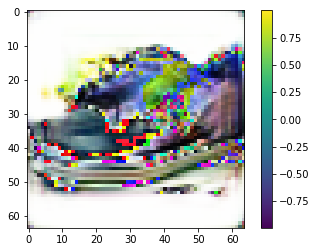

In [ ]:
n_epochs = 5000
display_ep = 10

batch_size = 64
n_critic = 5

for ep in range(n_epochs):
    for i in range(n_critic):
        d_train(sample_noise(batch_size, 100), sample_pics(batch_size))
        
    g_train(sample_noise(batch_size, 100))
    
    if ep % display_ep == 0:
        clear_output()
        print(ep)
        pic = generate(sample_noise(1, 100))
        plt.imshow(pic[0].transpose(1, 2, 0))
        plt.colorbar()
        plt.show()

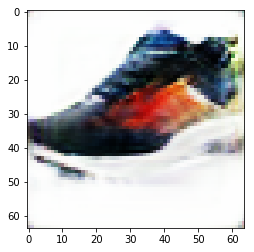

In [531]:
pic = generate(sample_noise(1, 100))
plt.imshow((pic[0].transpose(1, 2, 0)+1)/2)

(array([  800.,  2391.,   906.,   435.,   384.,   145.,   197.,   164.,
          220.,  6646.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

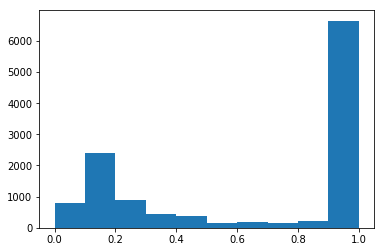

In [349]:
plt.hist(pics[0].transpose(1, 2, 0).ravel())

(array([  915.,  1056.,   808.,   512.,   382.,   377.,   277.,   243.,
          604.,  7114.]),
 array([ -9.99904871e-01,  -7.99940169e-01,  -5.99975467e-01,
         -4.00010765e-01,  -2.00046062e-01,  -8.13603401e-05,
          1.99883342e-01,   3.99848044e-01,   5.99812746e-01,
          7.99777448e-01,   9.99742150e-01]),
 <a list of 10 Patch objects>)

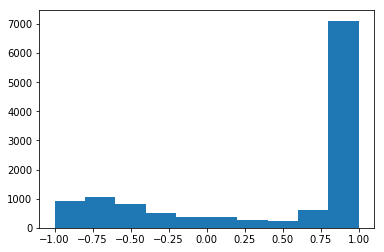

In [350]:
plt.hist(pic.ravel())

In [ ]:
import pickle 

with open("wgan_weights.pcl", "wb") as file:
    pickle.dump(lasagne.layers.get_all_param_values(generator), file)